In [9]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime
import geoip2.database

In [2]:
# Парсинг лог-файлу
def parse_log_line(line):
    pattern = re.compile(
        r'(?P<ip>\S+) - - \[(?P<datetime>[^\]]+)\] "(?P<method>\S+) (?P<url>\S+) (?P<protocol>\S+)" '
        r'(?P<status>\d+) (?P<length>\d+) "(?P<referrer>[^"]*)" "(?P<user_agent>[^"]*)"'
    )
    match = pattern.match(line)
    if match:
        return match.groupdict()
    return None

log_file = 'access.log'
data = []


In [3]:
with open(log_file) as file:
    for line in file:
        parsed_line = parse_log_line(line)
        if parsed_line:
            parsed_line['datetime'] = datetime.strptime(parsed_line['datetime'], '%d/%b/%Y:%H:%M:%S %z')
            data.append(parsed_line)

df = pd.DataFrame(data)

df['date'] = df['datetime'].dt.date
df['time'] = df['datetime'].dt.time
df['user_agent'] = df['user_agent'].str.lower()


In [4]:

def get_os(user_agent):
    if 'windows' in user_agent:
        return 'Windows'
    elif 'macintosh' in user_agent or 'mac os' in user_agent:
        return 'Mac OS'
    elif 'linux' in user_agent:
        return 'Linux'
    elif 'android' in user_agent:
        return 'Android'
    elif 'iphone' in user_agent or 'ipad' in user_agent:
        return 'iOS'
    else:
        return 'Other'

df['os'] = df['user_agent'].apply(get_os)

In [5]:
users_per_day = df.groupby('date')['ip'].nunique()
print(users_per_day)

date
2015-05-17    325
2015-05-18    584
2015-05-19    526
2015-05-20    478
Name: ip, dtype: int64


In [6]:
user_agent_rank = df['user_agent'].value_counts()
print(user_agent_rank)

user_agent
mozilla/5.0 (windows nt 6.1; wow64) applewebkit/537.36 (khtml, like gecko) chrome/32.0.1700.107 safari/537.36              866
universalfeedparser/4.2-pre-314-svn +http://feedparser.org/                                                                364
mozilla/5.0 (macintosh; intel mac os x 10_9_1) applewebkit/537.36 (khtml, like gecko) chrome/33.0.1750.91 safari/537.36    305
mozilla/5.0 (windows nt 6.1; wow64; rv:27.0) gecko/20100101 firefox/27.0                                                   295
mozilla/5.0 (x11; linux x86_64) applewebkit/537.36 (khtml, like gecko) chrome/32.0.1700.107 safari/537.36                  267
                                                                                                                          ... 
mozilla/4.0 (compatible; msie 6.0; windows nt 5.1; sv1; http://www.tropicdesigns.net)                                        1
mozilla/5.0 (compatible; googlebot/2.1;+http://www.google.com/bot.html)                             

In [7]:
os_rank = df['os'].value_counts()
print(os_rank)

os
Windows    3047
Other      2296
Linux      2257
Mac OS     1697
Android      27
iOS           6
Name: count, dtype: int64


In [10]:
reader = geoip2.database.Reader('GeoLite2-City.mmdb')
def get_country(ip):
    try:
        response = reader.city(ip)
        return response.country.name
    except:
        return 'Unknown'

df['country'] = df['ip'].apply(get_country)
country_rank = df['country'].value_counts()
print(country_rank)

country
United States          3583
France                  855
Germany                 546
India                   413
Sweden                  364
                       ... 
Oman                      1
Kuwait                    1
Trinidad and Tobago       1
Azerbaijan                1
Ghana                     1
Name: count, Length: 96, dtype: int64


In [11]:
bots = df[df['user_agent'].str.contains('bot|spider|crawl', regex=True)]
print(bots)

                   ip                  datetime method  \
30      66.249.73.135 2015-05-17 10:05:40+00:00    GET   
32      66.249.73.185 2015-05-17 10:05:37+00:00    GET   
39      123.125.71.35 2015-05-17 10:05:46+00:00    GET   
42    207.241.237.225 2015-05-17 10:05:58+00:00    GET   
47      66.249.73.185 2015-05-17 10:05:00+00:00    GET   
...               ...                       ...    ...   
9271       5.10.83.21 2015-05-20 21:05:36+00:00    GET   
9273    66.249.73.135 2015-05-20 21:05:18+00:00    GET   
9321    66.249.73.135 2015-05-20 21:05:11+00:00    GET   
9325    100.43.83.137 2015-05-20 21:05:01+00:00    GET   
9328    66.249.73.135 2015-05-20 21:05:00+00:00    GET   

                                           url  protocol status length  \
30                             /blog/tags/ipv6  HTTP/1.1    200  12251   
32                                           /  HTTP/1.1    200  37932   
39                          /blog/tags/release  HTTP/1.1    200  40693   
42     

In [12]:
# Детектування аномалій (наприклад, велика кількість запитів з одного ІР за короткий період)
ip_request_counts = df.groupby('ip').size()
anomalies = ip_request_counts[ip_request_counts > ip_request_counts.mean() + 3 * ip_request_counts.std()]
print(anomalies)

ip
108.171.116.194     65
130.237.218.86     293
198.46.149.143      82
208.115.111.72      73
208.115.113.88      66
208.91.156.11       60
209.85.238.199     102
46.105.14.53       364
50.16.19.13        113
65.55.213.73        59
66.249.73.135      432
68.180.224.225      95
75.97.9.59          99
dtype: int64


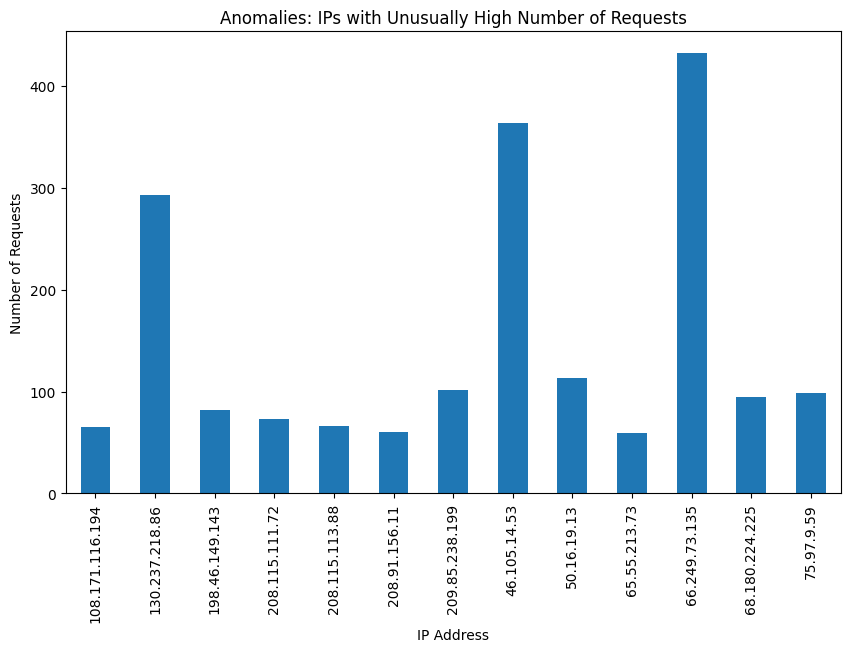

In [14]:
plt.figure(figsize=(10, 6))
anomalies.plot(kind='bar')
plt.title('Anomalies: IPs with Unusually High Number of Requests')
plt.xlabel('IP Address')
plt.ylabel('Number of Requests')
plt.show()